In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1.1 Create Cashflow Matrix

A Treasury bond with face value $F = 100$, annual coupon rate $c$, and maturity $T$ has:
- **Semiannual coupon**: $C = \frac{c \cdot 100}{2}$ paid every 6 months
- **Principal**: $F = 100$ paid at maturity

The **dirty price** equals the present value of all cashflows:

$$P_i = \sum_{j=1}^{n_i} C_{i,j} \cdot Z(t_j)$$

where $Z(t_j)$ is the discount factor at time $t_j$.

### The Cashflow Matrix $\mathbf{C}$

We construct a matrix $\mathbf{C} \in \mathbb{R}^{N \times M}$ where:
- $N$ = number of bonds
- $M$ = number of unique payment dates
- $C_{i,j}$ = cashflow from bond $i$ at date $t_j$

$$C_{i,j} = \begin{cases}
\frac{c_i}{2} + 100 & \text{if } t_j = T_i \text{ (maturity)} \\
\frac{c_i}{2} & \text{if } t_j \text{ is a coupon date} \\
0 & \text{otherwise}
\end{cases}$$

### Linear System

All bond prices can be expressed as:

$$\mathbf{p} = \mathbf{C} \mathbf{z}$$

where:
- $\mathbf{p} = [P_1, \ldots, P_N]^T$ = vector of dirty prices
- $\mathbf{z} = [Z(t_1), \ldots, Z(t_M)]^T$ = vector of discount factors
- $\mathbf{C}$ = cashflow matrix

This is an **overdetermined system** ($N > M$) since bonds share payment dates. We solve using least squares to estimate $\mathbf{z}$.

### Example
Bond with 4% coupon maturing in 1 year:
$$\mathbf{C}_i = \begin{bmatrix} 2 & 102 \end{bmatrix}, \quad P_i = 2 \cdot Z(0.5) + 102 \cdot Z(1.0)$$

In [2]:
# Load data
data1 = pd.read_excel('data/treasury_quotes_2025-11-28.xlsx', sheet_name='selected quotes')

# Convert dates
data1[['quote date', 'issue date', 'maturity date']] = data1[['quote date', 'issue date', 'maturity date']].apply(pd.to_datetime)
quote_date = data1['quote date'].iloc[0]

# Generate cashflows - FIXED VERSION matching classmate
cashflow_matrix = {}

for idx, row in data1.iterrows():
    issue_date = row['issue date']
    maturity_date = row['maturity date']
    coupon_pmt = row['cpn rate'] / 2  # Semiannual coupon
    
    # Generate dates from issue to maturity using 6MS (month-start)
    cashflow_dates = pd.date_range(start=issue_date, end=maturity_date, freq='6MS')
    
    # If maturity date doesn't match last generated date, append it
    if len(cashflow_dates) == 0 or cashflow_dates[-1] != maturity_date:
        cashflow_dates = cashflow_dates.append(pd.DatetimeIndex([maturity_date]))
    
    # Assign cashflows
    cashflows = {}
    for date in cashflow_dates:
        if date == maturity_date:
            cashflows[date] = coupon_pmt + 100
        else:
            cashflows[date] = coupon_pmt
    
    cashflow_matrix[idx] = cashflows

# Build cashflow matrix
all_dates = sorted(set(date for bond_cf in cashflow_matrix.values() for date in bond_cf.keys()))
C = pd.DataFrame(0.0, index=data1.index, columns=all_dates)

for bond_id, cashflows in cashflow_matrix.items():
    for date, amount in cashflows.items():
        C.loc[bond_id, date] = amount

print(f"Cashflow matrix shape: {C.shape}")

Cashflow matrix shape: (20, 45)


## 1.2 Solve for Discount Factors

In [3]:
# Solve for discount factors
p = data1['dirty price'].values
C_mat = C.values

z_vec = np.linalg.lstsq(C_mat, p, rcond=None)[0]

# Create discount factors DataFrame
discount_factors_df = pd.DataFrame({
    'date': C.columns,
    'discount_factor': z_vec
})

discount_factors_df['ttm'] = (discount_factors_df['date'] - quote_date).dt.days / 365.25

## 1.3 Filter to Maturity Dates and Calculate Rates

In [4]:
# Filter to ONLY maturity dates (like classmate does)
maturity_dates = []
for idx, row in data1.iterrows():
    mat_date = row['maturity date']
    if mat_date in discount_factors_df['date'].values:
        maturity_dates.append(mat_date)

maturity_df = discount_factors_df[discount_factors_df['date'].isin(maturity_dates)].copy()
maturity_df = maturity_df[maturity_df['ttm'] > 0].sort_values('ttm')

# Calculate rates
maturity_df['rate_sa'] = 2 * (maturity_df['discount_factor']**(-1/(2*maturity_df['ttm'])) - 1)
maturity_df['rate_cc'] = -np.log(maturity_df['discount_factor']) / maturity_df['ttm']

print(f"Number of maturity points: {len(maturity_df)}")
print("\nDiscount factors and rates:")
print(maturity_df[['ttm', 'discount_factor', 'rate_sa', 'rate_cc']])

Number of maturity points: 20

Discount factors and rates:
         ttm  discount_factor   rate_sa   rate_cc
6   0.503765         0.979053  0.042468  0.042023
8   1.004791         0.978800  0.021440  0.021325
10  1.503080         0.978103  0.014785  0.014730
12  2.004107         0.958148  0.021447  0.021333
14  2.505133         0.958540  0.016975  0.016903
16  3.006160         0.964982  0.011893  0.011858
18  3.504449         0.966323  0.009799  0.009775
20  4.005476         0.959386  0.010378  0.010351
22  4.503765         0.958096  0.009527  0.009505
24  5.004791         0.928574  0.014862  0.014807
26  5.503080         0.960740  0.007291  0.007278
28  6.004107         0.945323  0.009387  0.009365
30  6.505133         0.946112  0.008534  0.008516
32  7.006160         0.914701  0.012766  0.012726
34  7.460643         0.881774  0.016936  0.016864
36  7.964408         0.923764  0.009981  0.009957
38  8.459959         0.917409  0.010215  0.010189
40  8.963723         0.911697  0.010340  

## 1.4 Plot Results

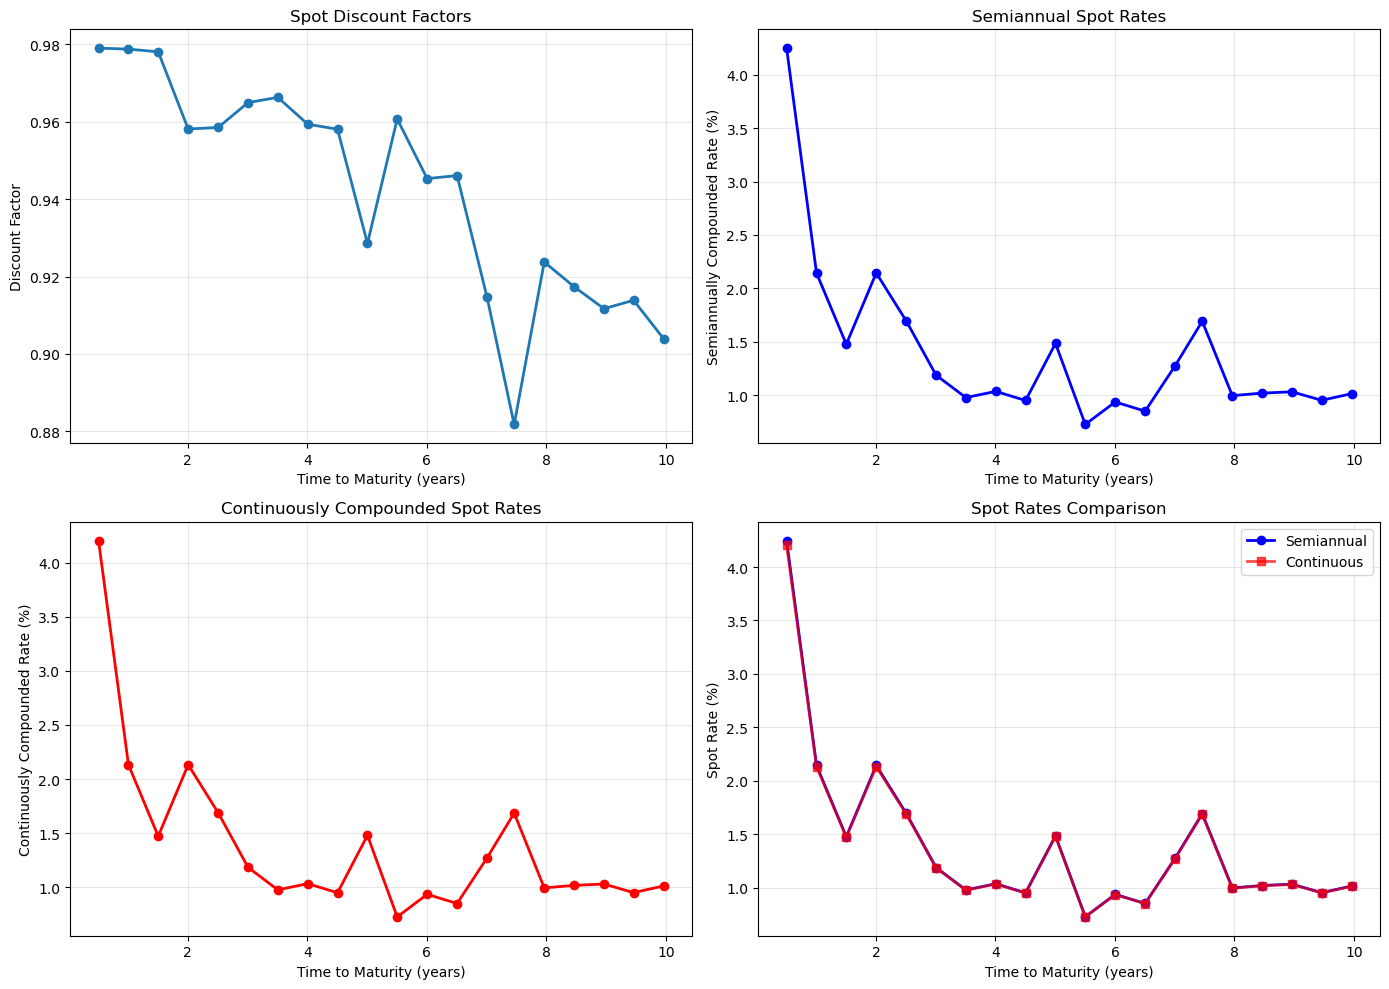

In [5]:
# Plot 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Discount Factors
axes[0, 0].plot(maturity_df['ttm'], maturity_df['discount_factor'], 'o-', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Time to Maturity (years)')
axes[0, 0].set_ylabel('Discount Factor')
axes[0, 0].set_title('Spot Discount Factors')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Semiannual Rates
axes[0, 1].plot(maturity_df['ttm'], maturity_df['rate_sa'] * 100, 'o-', linewidth=2, markersize=6, color='blue')
axes[0, 1].set_xlabel('Time to Maturity (years)')
axes[0, 1].set_ylabel('Semiannually Compounded Rate (%)')
axes[0, 1].set_title('Semiannual Spot Rates')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Continuous Rates
axes[1, 0].plot(maturity_df['ttm'], maturity_df['rate_cc'] * 100, 'o-', linewidth=2, markersize=6, color='red')
axes[1, 0].set_xlabel('Time to Maturity (years)')
axes[1, 0].set_ylabel('Continuously Compounded Rate (%)')
axes[1, 0].set_title('Continuously Compounded Spot Rates')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Combined
axes[1, 1].plot(maturity_df['ttm'], maturity_df['rate_sa'] * 100, 'o-', linewidth=2, markersize=6, color='blue', label='Semiannual')
axes[1, 1].plot(maturity_df['ttm'], maturity_df['rate_cc'] * 100, 's-', linewidth=2, markersize=6, color='red', alpha=0.7, label='Continuous')
axes[1, 1].set_xlabel('Time to Maturity (years)')
axes[1, 1].set_ylabel('Spot Rate (%)')
axes[1, 1].set_title('Spot Rates Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Nelson-Siegel Model

### Model Specification

Continuously compounded spot rate curve:

$$r(t) = \beta_0 + \beta_1 \frac{1 - e^{-t/\tau}}{t/\tau} + \beta_2 \left(\frac{1 - e^{-t/\tau}}{t/\tau} - e^{-t/\tau}\right)$$

**Parameters:**
- $\beta_0$ = level (long-term rate)
- $\beta_1$ = slope (short-term component, $r(0) = \beta_0 + \beta_1$)
- $\beta_2$ = curvature (medium-term hump)
- $\tau$ = decay (controls curvature location)

### Estimation

Minimize sum of squared errors against OLS rates:

$$\min_{\beta_0, \beta_1, \beta_2, \tau} \sum_{i=1}^{N} \left(r_i^{OLS} - r(t_i)\right)^2$$

### Rate Conversions

**Discount factor:**
$$Z(t) = e^{-r(t) \cdot t}$$

**Semiannual rate:**
$$r_{sa}(t) = 2\left(Z(t)^{-1/(2t)} - 1\right)$$

### Advantages
- **Smooth** curves (no arbitrage opportunities)
- **Parsimonious** (4 parameters vs 20+ for OLS)
- **Interpretable** (parameters have economic meaning)

=== Nelson-Siegel Parameters ===
β₀ (level):      0.009566 (0.9566%)
β₁ (slope):      0.073176 (7.3176%)
β₂ (curvature):  -0.056003 (-5.6003%)
τ (decay):       0.500000 years
Success: True


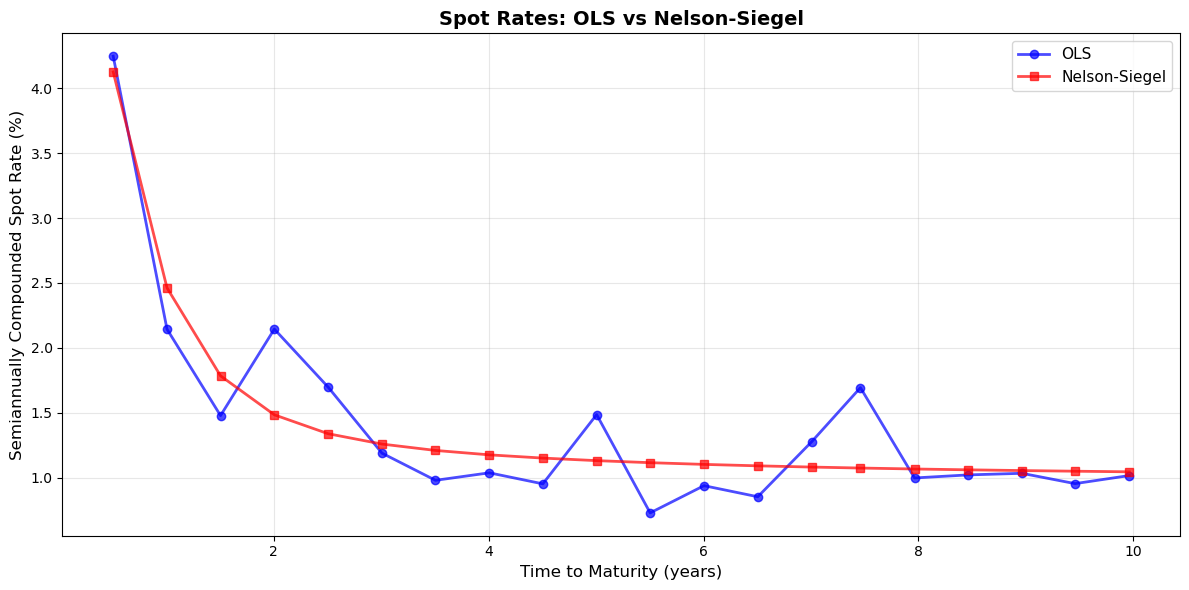


=== Fit Quality ===
Mean Absolute Error: 23.06 bps
Max Absolute Error:  66.02 bps
RMSE:                29.05 bps


In [9]:
from scipy.optimize import minimize

def nelson_siegel_rate(ttm, beta0, beta1, beta2, tau):
    """Nelson-Siegel continuously compounded spot rate."""
    # Handle division by zero for very small ttm
    ttm = np.maximum(ttm, 1e-10)
    tau = np.maximum(tau, 0.1)  # Prevent numerical issues
    
    x = ttm / tau
    exp_x = np.exp(-x)
    
    term1 = beta0
    term2 = beta1 * (1 - exp_x) / x
    term3 = beta2 * ((1 - exp_x) / x - exp_x)
    
    return term1 + term2 + term3

def ns_objective(params, ttm, observed_rates):
    """Sum of squared errors between NS rates and observed rates."""
    beta0, beta1, beta2, tau = params
    predicted_rates = nelson_siegel_rate(ttm, beta0, beta1, beta2, tau)
    return np.sum((observed_rates - predicted_rates) ** 2)

# Use OLS continuous rates as target
maturity_ttm = maturity_df['ttm'].values
ols_rates_cc = maturity_df['rate_cc'].values

# Initial guess and bounds
initial_params = [0.04, -0.01, 0.0, 2.0]
bounds = [(0.0, 0.15), (-0.15, 0.15), (-0.15, 0.15), (0.5, 10.0)]

# Optimize
result = minimize(
    ns_objective,
    initial_params,
    args=(maturity_ttm, ols_rates_cc),
    method='L-BFGS-B',
    bounds=bounds
)

beta0, beta1, beta2, tau = result.x

print("=== Nelson-Siegel Parameters ===")
print(f"β₀ (level):      {beta0:.6f} ({beta0*100:.4f}%)")
print(f"β₁ (slope):      {beta1:.6f} ({beta1*100:.4f}%)")
print(f"β₂ (curvature):  {beta2:.6f} ({beta2*100:.4f}%)")
print(f"τ (decay):       {tau:.6f} years")
print(f"Success: {result.success}")

# Generate NS rates
ns_rates_cc = nelson_siegel_rate(maturity_ttm, beta0, beta1, beta2, tau)
ns_discount = np.exp(-ns_rates_cc * maturity_ttm)
ns_rates_sa = 2 * (ns_discount ** (-1 / (2 * maturity_ttm)) - 1)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(maturity_df['ttm'], maturity_df['rate_sa'] * 100, 
        'o-', label='OLS', markersize=6, linewidth=2, color='blue', alpha=0.7)
ax.plot(maturity_ttm, ns_rates_sa * 100, 
        's-', label='Nelson-Siegel', markersize=6, linewidth=2, color='red', alpha=0.7)
ax.set_xlabel('Time to Maturity (years)', fontsize=12)
ax.set_ylabel('Semiannually Compounded Spot Rate (%)', fontsize=12)
ax.set_title('Spot Rates: OLS vs Nelson-Siegel', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Error statistics
rate_diff_bps = (maturity_df['rate_sa'].values - ns_rates_sa) * 10000
print(f"\n=== Fit Quality ===")
print(f"Mean Absolute Error: {np.mean(np.abs(rate_diff_bps)):.2f} bps")
print(f"Max Absolute Error:  {np.max(np.abs(rate_diff_bps)):.2f} bps")
print(f"RMSE:                {np.sqrt(np.mean(rate_diff_bps**2)):.2f} bps")

The OLS spot curve exactly matches bond prices but exhibits local irregularities because discount factors at longer maturities are weakly identified. The Nelson–Siegel curve smooths through these irregularities by imposing a parsimonious functional form, preserving the overall level and slope of the term structure while removing estimation noise.